<a href="https://colab.research.google.com/github/iey704/ComputerVision/blob/main/Mixup%20Augmentation%2BRAdam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import time

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

from torch.utils.data import ConcatDataset

import numpy as np

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [4]:
### Custom Dataset ###
# Create DataLoader
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.mode = mode
    self.transform = transform

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)

    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)

In [5]:
### Data Preprocessing & Data Augmentation ###
transforms_train_origin = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),])
transforms_test = transforms.Compose([transforms.Resize((448,448)),transforms.ToTensor(),])

BATCH_SIZE = 32
train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

# mix up
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size, device=x.device, dtype=torch.long)  # GPU에 있는 x.device를 사용하여 인덱스를 GPU로 전송

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

train_loader = DataLoader(train_set_origin,batch_size=BATCH_SIZE,shuffle=True)

# Mixup된 이미지를 train_loader에 추가
train_set_mixup = []
for input, target in train_loader:
    mixed_input, target_a, target_b, lam = mixup_data(input, target, alpha=1.0)
    train_set_mixup.append((mixed_input, target_a, target_b, lam))

train_set_combined = ConcatDataset([train_set_origin,train_set_mixup])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))

# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
train_loader_mixup = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")

Num of each dataset:  2434 296 298
Loaded dataloader


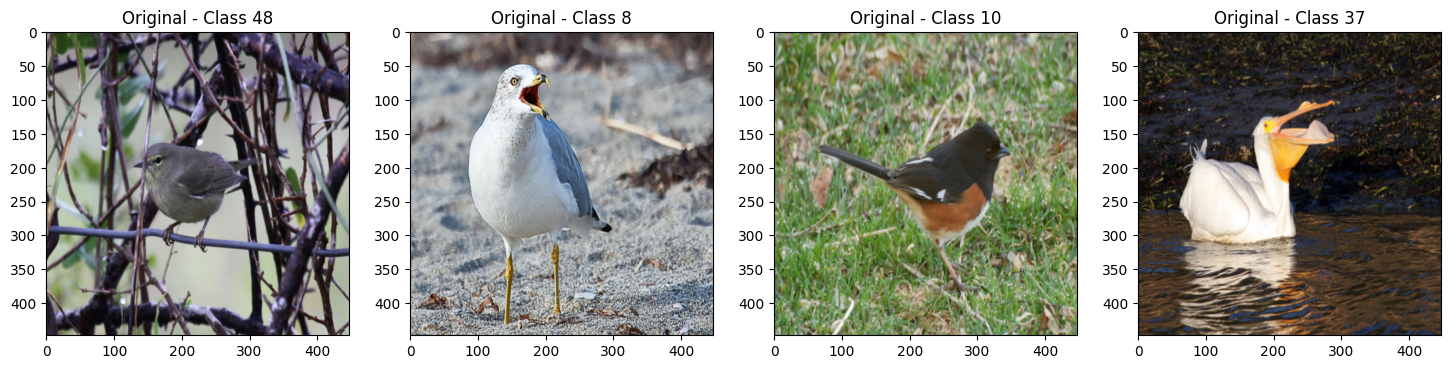

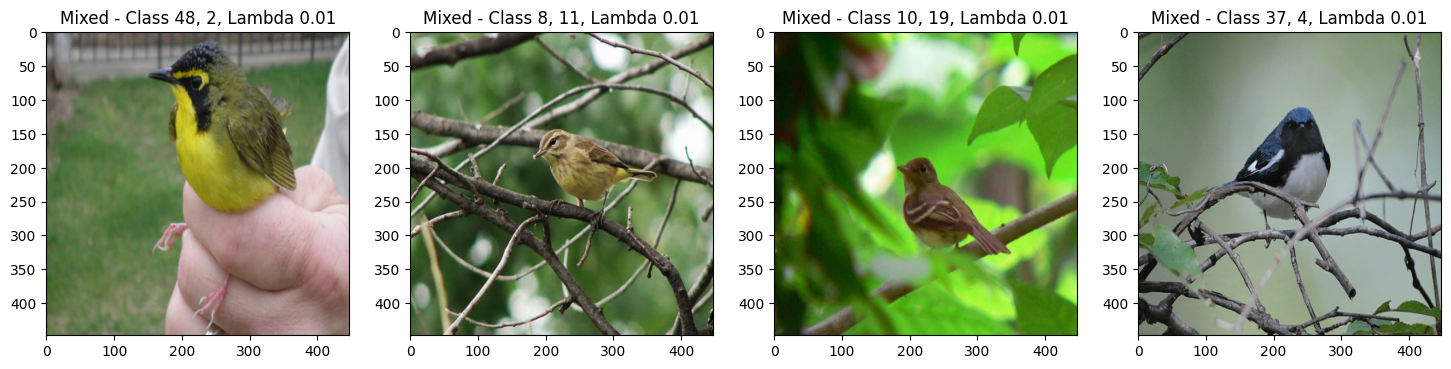

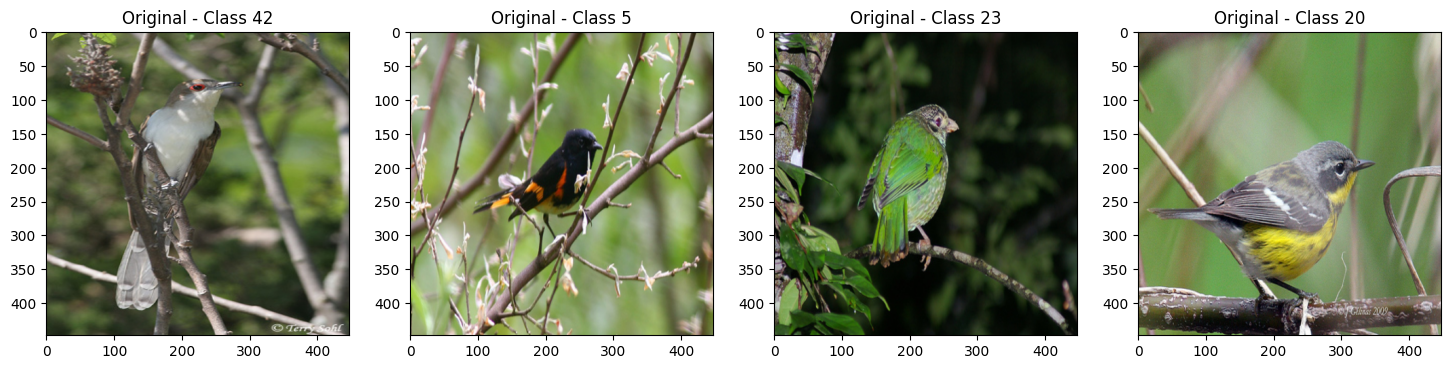

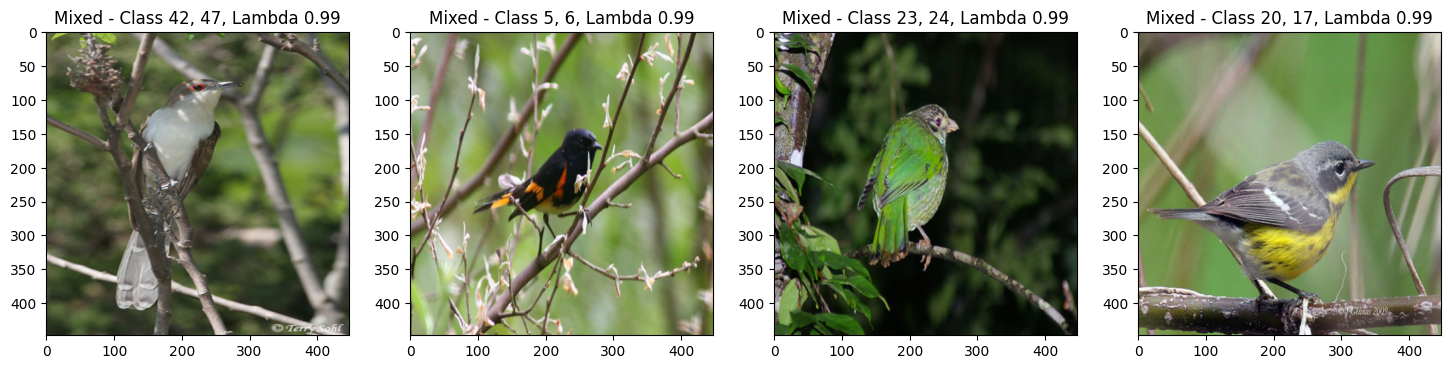

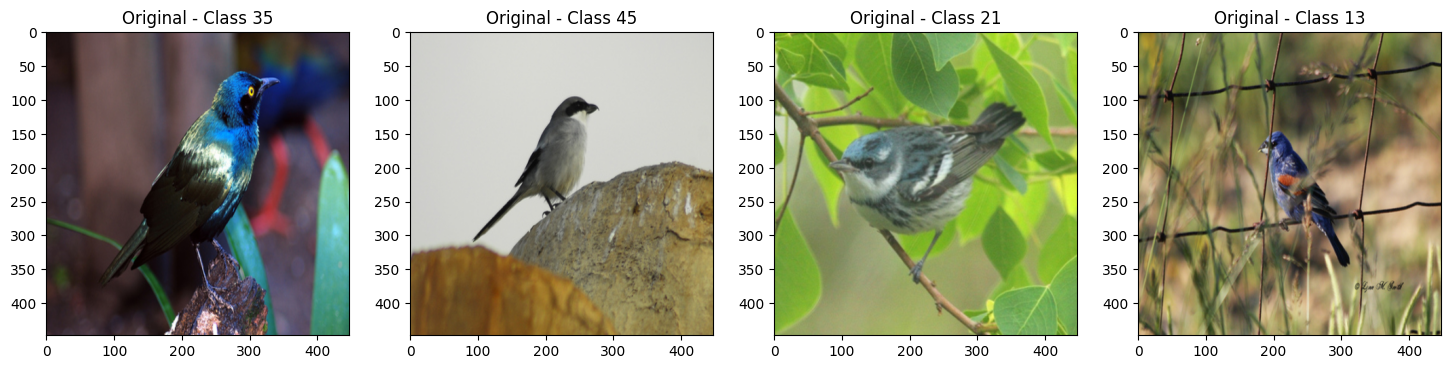

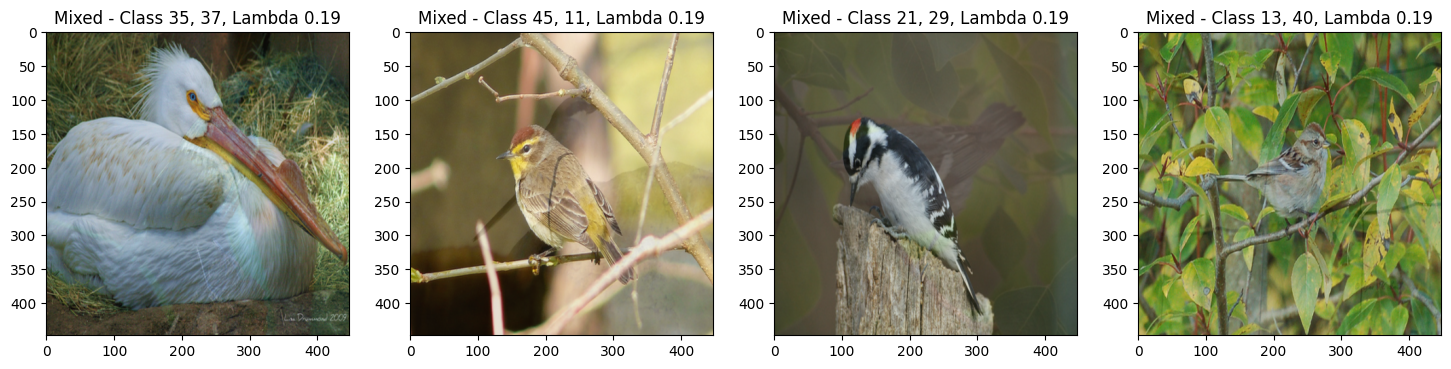

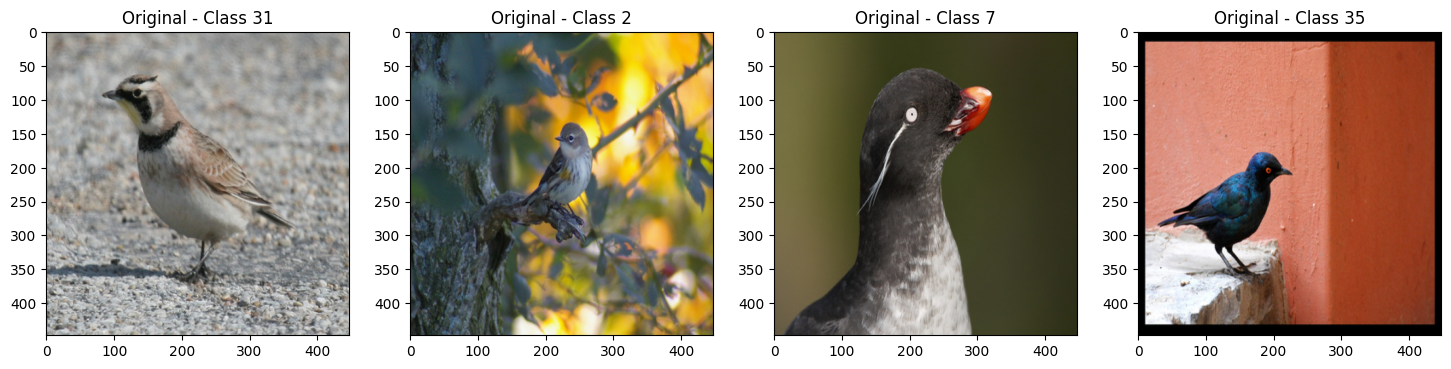

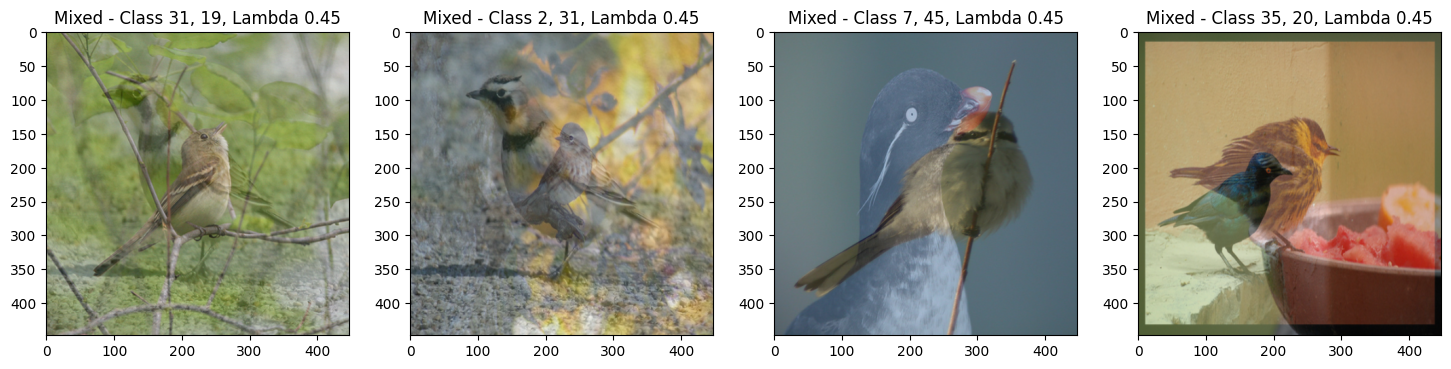

In [6]:
# Mixup된 이미지를 표시
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# 데이터 로더에서 몇 개의 배치를 가져와 Mixup을 적용하고 이미지를 표시
for i, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=1.0)

    plt.figure(figsize=(18, 18))
    for j in range(4):  # 처음 4개 이미지만 표시
        plt.subplot(1, 4, j + 1)
        imshow(inputs[j])
        plt.title(f"Original - Class {targets[j]}")

    plt.figure(figsize=(18, 18))
    for j in range(4):  # 처음 4개 이미지만 표시
        plt.subplot(1, 4, j + 1)
        imshow(mixed_inputs[j])
        plt.title(f"Mixed - Class {targets_a[j]}, {targets_b[j]}, Lambda {lam:.2f}")

    if i == 3:  # 예시로 4개의 배치만 표시
        break

plt.show()

In [7]:
!pip install git+https://github.com/LiyuanLucasLiu/RAdam.git

  Cloning https://github.com/LiyuanLucasLiu/RAdam.git to /tmp/pip-req-build-xgg98oep
  Running command git clone --filter=blob:none --quiet https://github.com/LiyuanLucasLiu/RAdam.git /tmp/pip-req-build-xgg98oep
  Resolved https://github.com/LiyuanLucasLiu/RAdam.git to commit d9fd30a337894c4003768561d45e8730dbd41333
  Preparing metadata (setup.py) ... done
  Created wheel for RAdam: filename=RAdam-0.0.1-py3-none-any.whl size=7098 sha256=cb92d997219ec7aa5c05f5217c5080aa844241baf46fa47ad4cf798c4fc0b393
  Stored in directory: /tmp/pip-ephem-wheel-cache-0zo_e5it/wheels/27/dd/f4/a154a2dd1d807820314f09ba2fa30f13f96a0d2830e8bab05e
Successfully built RAdam


In [8]:
# radam 사용
from radam import RAdam

# 스케줄러 사용
from torch.optim.lr_scheduler import CosineAnnealingLR

### Model / Optimizer ###
EPOCH = 30
lr = 0.001

model = models.resnet18(pretrained=True)

### Tranfer Learning ###
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,50)
model.to(DEVICE)

optimizer = optim.RAdam(model.parameters(),lr=lr)

# 스케줄러 초기화 (주기와 최소/최대 학습률 설정)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.001)

print("Created a learning model and optimizer")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.8MB/s]


Created a learning model and optimizer


In [9]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  model.train()
  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    # loss func을 어떤 것을 사용할 것인지?
    train_loss = F.cross_entropy(output,target).to(DEVICE)

    train_loss.backward()
    optimizer.step()

    # 스케줄러 업데이트
    scheduler.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [10]:

### Main ###
start = time.time()
best = 0
for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")


Train Epoch: 0 [0/74]	loss: 4.256392
Train Epoch: 0 [10/74]	loss: 4.033518
Train Epoch: 0 [20/74]	loss: 3.691054
Train Epoch: 0 [30/74]	loss: 3.400417
Train Epoch: 0 [40/74]	loss: 3.006346
Train Epoch: 0 [50/74]	loss: 2.784193
Train Epoch: 0 [60/74]	loss: 2.524296
Train Epoch: 0 [70/74]	loss: 2.054295
[0]Validation Loss: 2.0154,Accuracy: 55.0676%
Train Epoch: 1 [0/74]	loss: 2.103211
Train Epoch: 1 [10/74]	loss: 1.577121
Train Epoch: 1 [20/74]	loss: 1.646676
Train Epoch: 1 [30/74]	loss: 1.285347
Train Epoch: 1 [40/74]	loss: 1.283627
Train Epoch: 1 [50/74]	loss: 1.000238
Train Epoch: 1 [60/74]	loss: 1.072055
Train Epoch: 1 [70/74]	loss: 1.049096
[1]Validation Loss: 1.0628,Accuracy: 82.0946%
Train Epoch: 2 [0/74]	loss: 0.490925
Train Epoch: 2 [10/74]	loss: 0.622525
Train Epoch: 2 [20/74]	loss: 0.534778
Train Epoch: 2 [30/74]	loss: 0.579791
Train Epoch: 2 [40/74]	loss: 0.410394
Train Epoch: 2 [50/74]	loss: 0.367606
Train Epoch: 2 [60/74]	loss: 0.417573
Train Epoch: 2 [70/74]	loss: 0.281143